In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.io import savemat
import matplotlib.pyplot as plt 

def kMeans(X, K, maxIters = 20, plot_progress = None):

    centroids = X[np.random.choice(len(X), K)]
    for i in range(maxIters):
        # Cluster Assignment step
        C = np.array([np.argmin([(x_i-y_k)@(x_i-y_k) for y_k in centroids]) for x_i in X])
        # Update centroids step 
        centroids = []
        for k in range(K):
            if (C == k).any():
                centroids.append( X[C == k].mean(axis = 0) )
            else: # if there are no data points assigned to this certain centroid
                centroids.append( X[np.random.choice(len(X))] )
        if plot_progress != None: plot_progress(X, C, np.array(centroids))
    return np.array(centroids) , C

# def spikeSort()

        

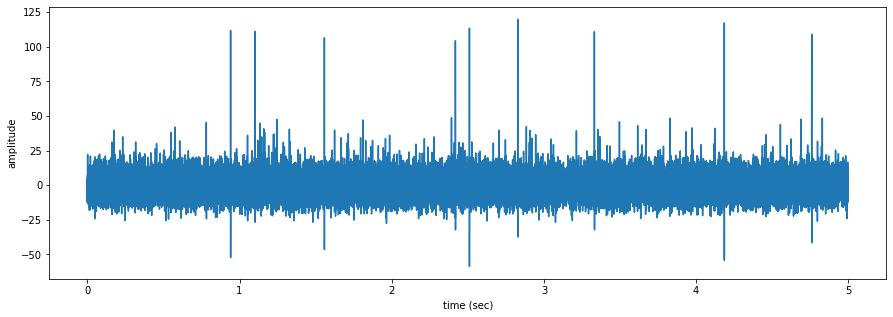

In [69]:
# load signal from file
file_in = loadmat("simulation_1.mat")

# uncomment this line for visibility
# print([key for key in file_in])

samplingInterval = file_in['samplingInterval'].item()/1000 # note: units in ms
startData = file_in['startData']
chan = file_in['chan']
data = file_in['data'].flatten()
spike_times = file_in['spike_times']
spike_class = file_in['spike_class']

# determine length of recording in seconds
rec_duration = data.shape[0]*samplingInterval

# length of sampled signal in seconds
samp_duration = 5
t = np.linspace(0,rec_duration,data.shape[0])
f_s = int(1/samplingInterval)

# display raw signal
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
ax.plot(t[0:samp_duration*f_s], data[0:samp_duration*f_s])
ax.set_xlabel('time (sec)')
ax.set_ylabel('amplitude')
plt.show()

# Preprocessing raw data

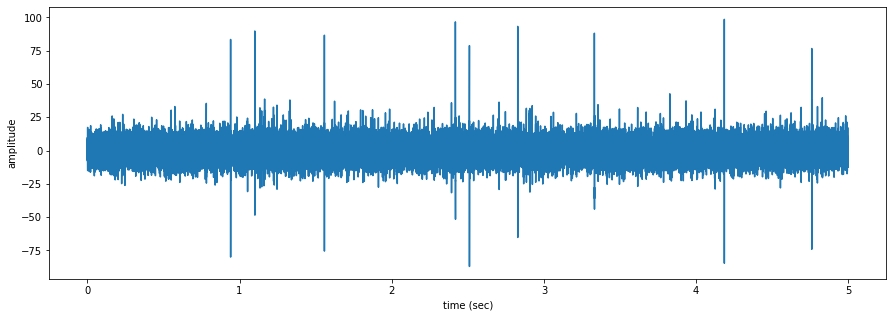

In [66]:
from scipy.signal import butter, lfilter

# preprocess raw data by bandpass filtering 300-6000 Hz range using a 2nd order IIR bandpass filter (Butterworth)
b, a = butter(2, [300/(f_s/2), 6000/(f_s/2)], btype='band')
filtered_data = lfilter(b, a, data)

# display filtered data
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
ax.plot(t[0:5*f_s], filtered_data[0:5*f_s])
ax.set_xlabel('time (sec)')
ax.set_ylabel('amplitude')
plt.show()

# Extracting spikes

In [73]:
## Determines where spikes occur given an input signal. The sliding window length can be adjusted.
#
## Inputs ##
#  data: input waveform
#  w:    window length (default: 100)
#  thr:  spike threshold (default: 40)
## Outputs ##
#  spike_waves: windowed spike waveforms
#  

def SpikeSort(data, w = 100, thr = 40):
    
    # determine where the data crosses specified threshold
    thr_crossing = np.where(data>thr)[0]
    thr_crossing = 
    
    # initialize waveform/spike locations
    spike_pos = []
    spike_waves = np.zeros([1,2*w])
    
    # extract all spikes for now (i = indices of threshold crossings)
    for i in thr_crossing:
        
        # capture the spike within the window
        if i < data.shape[0] - w+1:
            new_wave = data[i:i+w*2]
        
            # align waveform with peak sample
            new_pos = np.argmax(new_wave)+i
            wave = data[new_pos-(w-w/2):new_pos+(w+w/2)]
            
            # append windowed spike waveform
            spike_pos = np.append(spike_pos, new_pos)
            spike_waves = np.append(spike_waves, new_wave.reshape(1,2*w))
        
    # remove any duplicate spikes before returning
    
    return spike_pos, spike_waves

In [71]:
# determine a threshold to detect spikes
# suggested from Quiroga et. al (2004) for automatic thresholding: 5*sigma_n
# Note: sigma_n is an estimate of noise since spikes account for a very small portion of the samples. 
# Therefore we can take the standard deviation of the entire signal.
thr = 5*np.std(filtered_data)


34.74251124118949


In [ ]:
# perform PCA to reduce dimensionality, extract features



In [ ]:
# use k-means to cluster spikes with similar characteristics